In [1]:
import re
from pathlib import Path 
import itertools

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
%matplotlib inline
plt.style.use('seaborn')

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
class Dataset(Dataset):
    def __init__(self, path_X, path_Y, img_size=(128, 128)):
        self.to_tensor = transforms.Compose([
                                transforms.Resize(img_size), 
                                transforms.ToTensor()])
        self.re_number = re.compile('[0-9]')
        self.files_X = self._get_files_path(path_X)
        self.files_Y = self._get_files_path(path_Y)
        
    def __len__(self):
        return len(self.files_X)
    
    def __getitem__(self, idx):
        X = self.to_tensor(Image.open(self.files_X[idx]))
        Y = self.to_tensor(Image.open(self.files_Y[idx]))
        return X, Y
    
    def _get_file_numbers(self, path):
        filename = path.stem
        file_number = int(''.join(self.re_number.findall(filename)))
        return file_number
    
    def _get_files_path(self, directory):
        path_files = directory.glob('*')
        path_files = sorted(path_files, key=self._get_file_numbers)
        return path_files

<center> Utils

In [6]:
def save_pics(fake, real, 
              epoch: int, batch_idx: int, 
              dir_generated):
    path_fake = dir_generated.joinpath(f'fake_{epoch}_{batch_idx}.png')
    path_real = dir_generated.joinpath(f'real_{epoch}_{batch_idx}.png')
    # saving
    torchvision.utils.save_image(fake.data, 
                                 path_fake, 
                                 normalize=True)
    torchvision.utils.save_image(real.data, 
                                 path_real, 
                                 normalize=True)

In [7]:
def plot_losses(gen_losses_X, gen_losses_Y, dis_losses_X, dis_losses_Y, epoch: int):
    clear_output(True)
    fig, ax = plt.subplots(2, 2, figsize=(12, 9))
    
    ax[0, 0].plot(gen_losses_X)
    ax[0, 1].plot(gen_losses_Y) 
    ax[1, 0].plot(dis_losses_X) 
    ax[1, 1].plot(dis_losses_Y)
    
    ax[0, 0].set_title('Generator X | {}'.format(epoch))
    ax[0, 1].set_title('Generator Y | {}'.format(epoch))
    ax[1, 0].set_title('Discriminator X | {}'.format(epoch))
    ax[1, 1].set_title('Discriminator Y | {}'.format(epoch))
    
    plt.show()

In [8]:
def watch_generations(dataset, G_x, G_y, dir_generated_X, dir_generated_Y):
    # get random index 
    ind = np.random.randint(len(dataset))
    # generate
    with torch.no_grad():
        G_x.eval(), G_y.eval()
        x_real, y_real = dataset[ind]
        x_real, y_real = x_real.unsqueeze(0), y_real.unsqueeze(0)
        y_fake = G_x(x_real.to(device)).cpu()
        x_fake = G_y(y_real.to(device)).cpu()
    
    # saving pictures
    save_pics(y_fake, x_real,
              epoch=epoch, batch_idx=batch_idx, 
              dir_generated=dir_generated_X)
    save_pics(x_fake, y_real,
              epoch=epoch, batch_idx=batch_idx, 
              dir_generated=dir_generated_Y)

In [9]:
def save_weights(G_x, G_y, D_x, D_y, 
                 optimizer_G, optimizer_D, 
                 epoch: int):
    """ Save weight of models and their optimizers """
    
    path = models_dir.joinpath('gan_{}'.format(epoch))
    
    torch.save({
            'genX_state_dict': G_x.state_dict(),
            'genY_state_dict': G_y.state_dict(),
            'disX_state_dict': D_x.state_dict(),
            'disY_state_dict': D_y.state_dict(),
            'optimizerG_state_dict': optimizer_G.state_dict(),
            'optimizerD_state_dict': optimizer_D.state_dict(),
    }, path)

In [10]:
def load_weights(G_x, G_y, D_x, D_y, 
                 optimizer_G, optimizer_D,
                 epoch: int):
    path = models_dir.joinpath('gan_{}'.format(epoch))
    checkpoint = torch.load(path)
    
    G_x.load_state_dict(checkpoint['genX_state_dict'])
    G_y.load_state_dict(checkpoint['genY_state_dict'])
    D_x.load_state_dict(checkpoint['disX_state_dict'])
    D_y.load_state_dict(checkpoint['disY_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizerD_state_dict'])

In [11]:
def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean=0.0, std=0.02)

<center> Generator Layers </center>

In [12]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.refl_padding = nn.ReflectionPad2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=3, stride=2, padding=0)
        self.instance_norm = nn.InstanceNorm2d(out_channels)
        
    def forward(self, batch):
        batch = self.refl_padding(batch)
        batch = self.conv(batch)
        batch = self.instance_norm(batch)
        batch = F.relu(batch)
        return batch

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResidualBlock, self).__init__()
        self.refl_padding_1 = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=0)
        self.refl_padding_2 = nn.ReflectionPad2d(1)
        self.conv2 = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=0)
        
    def forward(self, batch):
        padded_batch = self.refl_padding_1(batch)
        conv_batch = self.conv1(padded_batch)
        padded_batch = self.refl_padding_2(conv_batch)
        conv_batch = self.conv2(padded_batch)
        out = batch + conv_batch
        return out

In [14]:
class Generator(nn.Module):
    def __init__(self, num_res=6):
        super(Generator, self).__init__()
        self.num_res = num_res
        # make layers
        self.refl_padding_1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=0)
        self.instance_norm1 = nn.InstanceNorm2d(32)
        self.dk_layer_1 = DownBlock(32, 64)
        self.dk_layer_2 = DownBlock(64, 128)
        self.res_blocks = nn.ModuleList([ResidualBlock(128) for _ in range(num_res)])
        
        self.conv_trans_1 = nn.ConvTranspose2d(128, 64, kernel_size=3, 
                                               stride=2, padding=1, 
                                               output_padding=1)
        self.instance_norm2 = nn.InstanceNorm2d(64)
        self.conv_trans_2 = nn.ConvTranspose2d(64, 32, kernel_size=3, 
                                               stride=2, padding=1, 
                                               output_padding=1)
        self.instance_norm3 = nn.InstanceNorm2d(32)
        self.refl_padding_2 = nn.ReflectionPad2d(3)
        self.conv2 = nn.Conv2d(32, 3, kernel_size=7, stride=1, padding=0)
        # init weights
        self.apply(weights_init)
        
    def forward(self, batch):
        # convolutions
        batch = self.refl_padding_1(batch)
        batch = self.conv1(batch)
        batch = self.instance_norm1(batch)
        batch = F.relu(batch)
        batch = self.dk_layer_1(batch)
        batch = self.dk_layer_2(batch)
        # resconnection blocks
        for i in range(self.num_res):
            batch = self.res_blocks[i](batch)
        # deconvolutions
        batch = self.conv_trans_1(batch)
        batch = self.instance_norm2(batch)
        batch = F.relu(batch)
        batch = self.conv_trans_2(batch)
        batch = self.instance_norm3(batch)
        batch = F.relu(batch)
        # out layers
        batch = self.refl_padding_2(batch)
        batch = self.conv2(batch)
        batch = torch.tanh(batch)
        return batch

<center> Discriminator Layers </center>

In [15]:
class ConvolutionNorm(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(ConvolutionNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, stride=stride, 
                              kernel_size=4, padding=1)
        self.instance_norm = nn.InstanceNorm2d(out_channels)
        
    def forward(self, batch, use_norm=True):
        batch = self.conv(batch)
        if use_norm:
            batch = self.instance_norm(batch)
        batch = F.leaky_relu(batch, 0.2)
        return batch

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = ConvolutionNorm(3, 64)
        self.conv2 = ConvolutionNorm(64, 128)
        self.conv3 = ConvolutionNorm(128, 256)
        self.conv4 = ConvolutionNorm(256, 512, stride=1)
        self.conv_out = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        self.apply(weights_init)
        
    def forward(self, batch):
        batch = self.conv1(batch, use_norm=False)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        outputs = self.conv4(batch)
        logits = self.conv_out(outputs)
        probs = torch.sigmoid(logits)
        return probs

<center> Loss Functions </center>

In [17]:
cycle_criterion = torch.nn.L1Loss()
identity_criterion = torch.nn.L1Loss()
mse_criterion = nn.MSELoss()

In [18]:
def discriminator_loss(discriminator, real_input, fake_input):
    prob_real = discriminator(real_input)
    ones = torch.ones_like(prob_real).to(prob_real.device)
    
    prob_fake = discriminator(fake_input)
    zeros = torch.zeros_like(prob_fake).to(prob_fake.device)
    
    real_loss = mse_criterion(prob_real, ones)
    fake_loss = mse_criterion(prob_fake, zeros)
    loss = (real_loss + fake_loss) / 2
    return loss

In [19]:
def generator_adversarial_loss(discriminator, fake_input):
    prob_fake = discriminator(fake_input)
    ones = torch.ones_like(prob_fake).to(prob_fake.device)
    loss = mse_criterion(prob_fake, ones)
    return loss

In [20]:
def identity_loss(proxy_input, real_input):
    """
    proxy_y := generator_x(real_y)
    """
    loss = identity_criterion(proxy_input, real_input)
    return loss

In [21]:
def generator_loss(real_input, 
                   fake_input, 
                   reconstr_input, 
                   discriminator, 
                   lambda_coef: float = 10., 
                   use_identity: bool = False,
                   proxy_input=None):
    """ Computes total loss for generator """
    
    adv_loss = generator_adversarial_loss(discriminator, fake_input)
    cycle_loss = cycle_criterion(reconstr_input, real_input)
    loss = adv_loss + lambda_coef * cycle_loss
    return loss

<center> Training </center>

In [22]:
def one_step(D_x, D_y, G_x, G_y, device,
             pass_steps=50, lambda_coef=10, 
             use_identity: bool = False):
    """ Makes one network step for GAN """
    G_x.train(), G_y.train()
    # which images pass to discriminator
    chosen_idx = np.random.randint(0, pass_steps)
    
    # Generators steps
    for batch_idx, (x, y) in enumerate(train_dataloader):
        optimizer_G.zero_grad()
        x, y = x.to(device), y.to(device)

        # generation
        fake_x = G_y(y)
        fake_y = G_x(x)
        # reconstruction
        rec_x = G_y(fake_y)
        rec_y = G_x(fake_x)

        # compute generator loss
        gen_loss_X = generator_loss(x, fake_x, rec_x,
                                    D_y, lambda_coef=lambda_coef)
        gen_loss_Y = generator_loss(y, fake_y, rec_y,
                                    D_x, lambda_coef=lambda_coef)
        gen_loss = gen_loss_X + gen_loss_Y

        #identity loss
        if use_identity:
            proxy_x = G_y(x)
            proxy_y = G_x(y)
            identity_loss_y = identity_loss(proxy_y, y)
            identity_loss_x = identity_loss(proxy_x, x)
            identity_loss_total = identity_loss_x + identity_loss_y
            gen_loss = gen_loss + 0.5 * lambda_coef * identity_loss_total

        gen_loss.backward()
        optimizer_G.step()

       # if pass steps bigger break
        if batch_idx >= pass_steps:
            break
            
    # Discriminators step
    optimizer_D.zero_grad()
    dis_loss_Y = discriminator_loss(D_x, y, fake_y.detach())
    dis_loss_X = discriminator_loss(D_y, x, fake_x.detach())
    dis_loss_X.backward()
    dis_loss_Y.backward()
    optimizer_D.step()
    losses = (gen_loss_X.cpu().item(), gen_loss_Y.cpu().item(), 
              dis_loss_X.cpu().item(), dis_loss_Y.cpu().item())
    return losses

<center> Parameters </center>

In [23]:
data_dir = Path('data/facades/')
train_path_X = data_dir.joinpath('trainA')
train_path_Y = data_dir.joinpath('trainB')
val_path_X = data_dir.joinpath('testA')
val_path_Y = data_dir.joinpath('testB')
dir_generated_X = data_dir.joinpath('fakeX')
dir_generated_Y = data_dir.joinpath('fakeY')
models_dir = Path('models/')

In [24]:
num_epochs = 200
batch_size = 1
pass_steps = 50
lr = 0.0002
img_size = (128, 128)
num_res = 6 if img_size == (128, 128) else 9
use_identity = False
num_res

6

In [25]:
# init dataset
train_dataset = Dataset(train_path_X, train_path_Y, img_size)
val_dataset = Dataset(val_path_X, val_path_Y, img_size)
# init loaders
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=1, 
                            shuffle=True, num_workers=6)

In [26]:
# Generators: G_x: X -> Y; G_y: Y -> X
# Discriminators: D_x: G_x(X) vs Y; D_y: G_y(Y) vs X
                    
D_x = Discriminator().to(device)
D_y = Discriminator().to(device)
G_x = Generator().to(device)
G_y = Generator().to(device)

In [27]:
optimizer_G = torch.optim.Adam(itertools.chain(G_x.parameters(), G_y.parameters()),
                               lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_x.parameters(), D_y.parameters()),
                               lr=lr, betas=(0.5, 0.999))

In [28]:
if False:
    epoch = None
    load_weights(G_x, G_y, D_x, D_y, 
                 optimizer_G, optimizer_D, 
                 epoch)

In [29]:
def update_lr(epoch):
    return 0.99 ** (epoch - 100)

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=update_lr)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=update_lr)

In [30]:
epoch = 0
gen_losses_X, gen_losses_Y = [], []
dis_losses_X, dis_losses_Y = [], []

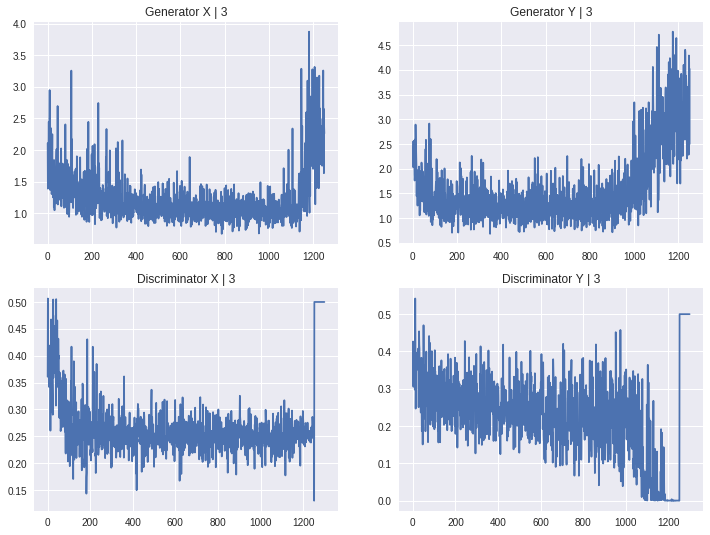

3_100: pic saved


Traceback (most recent call last):
  File "/home/dulat/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/dulat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dulat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/dulat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/dulat/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/dulat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dulat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(he

KeyboardInterrupt: 

In [31]:
%%time
while epoch <= num_epochs:
    for batch_idx, (X, Y) in enumerate(train_dataloader):
        # optimize
        losses = one_step(D_x, D_y, G_x, G_y, 
                          device=device, 
                          pass_steps=pass_steps, 
                          use_identity=use_identity)
        # losses
        gen_loss_X, gen_loss_Y, dis_loss_X, dis_loss_Y = losses
        gen_losses_X.append(gen_loss_X)
        gen_losses_Y.append(gen_loss_Y) 
        dis_losses_X.append(dis_loss_X)
        dis_losses_Y.append(dis_loss_Y)
        
        # save fake and real images
        if batch_idx % 100 == 0:
            watch_generations(val_dataset, G_x, G_y, 
                              dir_generated_X, dir_generated_Y)
            plot_losses(gen_losses_X, gen_losses_Y, 
                      dis_losses_X, dis_losses_Y, epoch)
            print(f'{epoch}_{batch_idx}: pic saved')
    
    # saving model
    save_weights(G_x, G_y, D_x, D_y, 
                 optimizer_G, optimizer_D, 
                 epoch=epoch)
         
    # make step for scheduler
    if epoch >= 100:
        scheduler_G.step()
        scheduler_D.step()
        
    epoch += 1

#### Watch Results

In [105]:
epoch = 13
load_weights(G_x, G_y, D_x, D_y, 
             optimizer_G, optimizer_D, 
             epoch)

In [132]:
idx = np.random.randint(len(train_dataset))
print(idx)
X, Y = train_dataset[idx]
fake_Y = G_x(X.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
fake_X = G_y(Y.unsqueeze(0).to(device)).detach().cpu().squeeze(0)

292


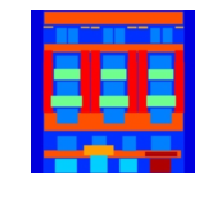

In [133]:
plt.figure(figsize=(3, 3))
plt.imshow(Y.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


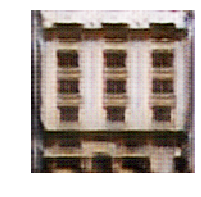

In [134]:
plt.figure(figsize=(3, 3))
plt.imshow(fake_X.permute(1, 2, 0).numpy())
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


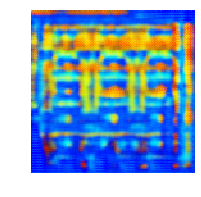

In [135]:
plt.figure(figsize=(3, 3))
plt.imshow(fake_Y.permute(1, 2, 0).numpy())
plt.axis('off');

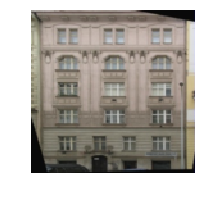

In [136]:
plt.figure(figsize=(3, 3))
plt.imshow(X.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off');